<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/tim-updates/code/tim-wiki-eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wikipedia Article EDA Notebook

In [10]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [6]:
urls = ['https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/dale_chall.txt',
        'https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/Concreteness_ratings_Brysbaert_et_al_BRM.txt',
        'https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/AoA_51715_words.csv',
        'https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/WikiLarge_Train.csv',
        'https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/WikiLarge_Test.csv',
        'https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/sampleSubmission.csv']

d_chall = requests.get(urls[0]).text.split('\r')
conc_df = pd.read_csv(urls[1], sep='\t')
aoa_df = pd.read_csv(urls[2], encoding_errors='ignore')

wiki_df_train = pd.read_csv(urls[3])
# The labels column is purely null values so I'm going to throw it away
wiki_df_test = pd.read_csv(urls[4], usecols=['id', 'original_text']).set_index('id')
sample_df = pd.read_csv(urls[5]).set_index('id')

## Word Frequencies and sentence Lengths

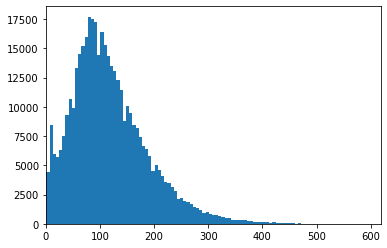

In [24]:
def plot_sentence_character_lengths(wiki_df):
  sentence_lengths = wiki_df['original_text'].apply(len)
  plt.hist(sentence_lengths, bins=100)
  plt.xlim(0)
  plt.show()

plot_sentence_character_lengths(wiki_df_train)

Top 10 sentences with 3 or less characters

In [37]:
(wiki_df_train[wiki_df_train['original_text'].apply(len) < 4]
 ['original_text']
 .value_counts()
 .sort_values(ascending=False)
 .head(10))

!      111
.      109
The     55
C.      25
New     17
A       17
--      17
jpg     15
,       13
png     13
Name: original_text, dtype: int64

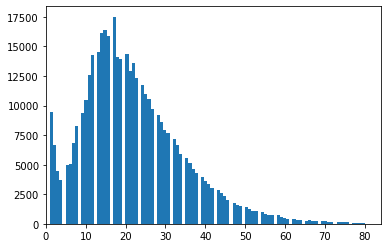

In [40]:
def plot_sentence_word_frequencies(wiki_df):
  # For this exerices I will use the Python split method to tokenize my sentences
  word_freqs = wiki_df['original_text'].apply(lambda x: len(x.split(' ')))
  plt.hist(word_freqs, bins=100)
  plt.xlim(0)
  plt.show()

plot_sentence_word_frequencies(wiki_df_train)

Top 12 single-token sentences

In [39]:
(wiki_df_train[wiki_df_train['original_text'].apply(lambda x: len(x.split(' '))) == 1]
 ['original_text']
 .value_counts()
 .sort_values(ascending=False)
 .head(12))

References    1051
History        265
Official       159
Deaths         142
Events         140
Births         123
!              111
.              109
#NAME?          63
Name            56
The             55
Life            55
Name: original_text, dtype: int64